## Housing Price Estimates 

- Data Source: `Kaggle`


#### Tasks:
- **Data Pre-Processing**
- **EDA**
- **Merge Additional Data by geo/zip**
- **K-Means Clustering**
- **Estimate Price**

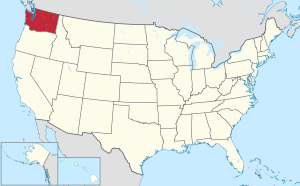

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as SPLIT
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv('/Users/sandeepk/Desktop/_Spatial_/Final_550/WA_house_data.csv')
df_raw.head(2)

,OID_,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1,7.129301e+09,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2,6.414100e+09,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


## Merge Additional Data
- `Zip` or `city` as **Primary Key**
- Crime Data, Population Data, etc.

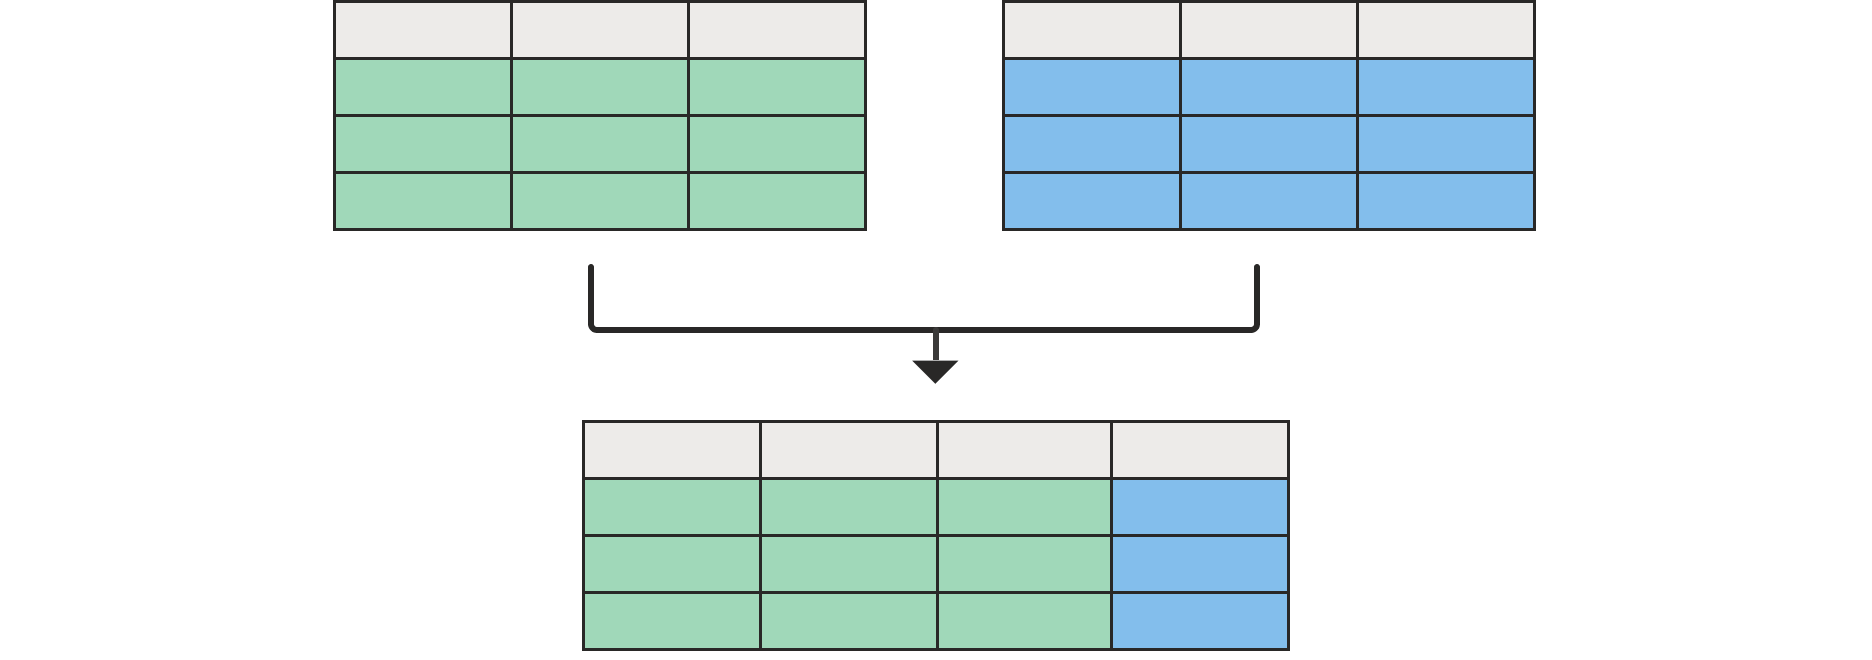

In [3]:
#Population Data #ON QI DATA
zip_df = pd.read_csv('population_by_zip_2010.csv').groupby('zipcode')['population'].max().reset_index() 
df_raw = df_raw.merge(zip_df, left_on='zipcode', right_on='zipcode', how='left') #Relational Join

In [4]:
#School Data

## Cleansing 🧽
- Null Values Omitted
- Outliers exceding 3 Z-scores (99.7% data distribution) extracted 

In [4]:
#Output z-score ranges for data distribution of a feature
def dist_range(df, col, z): 
    upper = round(df[col].mean() + (df[col].std())*z,4)
    lower = round(df[col].mean() - (df[col].std())*z,4)
    if lower<0:lower=0
    print(f'{col.title()} {z} Z-scores of Data: ({lower},{upper})') 

In [5]:
dist_range(df_raw, 'bathrooms',3) #QI DATA
dist_range(df_raw, 'bedrooms',3)
dist_range(df_raw, 'sqft_living',3)
dist_range(df_raw, 'price',3)

Bathrooms 3 Z-scores of Data: (0,4.4252)
Bedrooms 3 Z-scores of Data: (0.5807,6.161)
Sqft_Living 3 Z-scores of Data: (0,4835.2224)
Price 3 Z-scores of Data: (0,1641469.7312)


In [6]:
# Remove Outliers in Analysis Columns
df = df_raw.query('bathrooms <=5 and bedrooms <=7 and sqft_living <= 4500 and price<1500000')

In [7]:
import scipy
#Kurtosis, Original + Cleansed
scipy.stats.kurtosis(np.array(df_raw['price'])),  scipy.stats.kurtosis(np.array(df['price'])) 

(34.577262255687536, 1.6373459257029523)

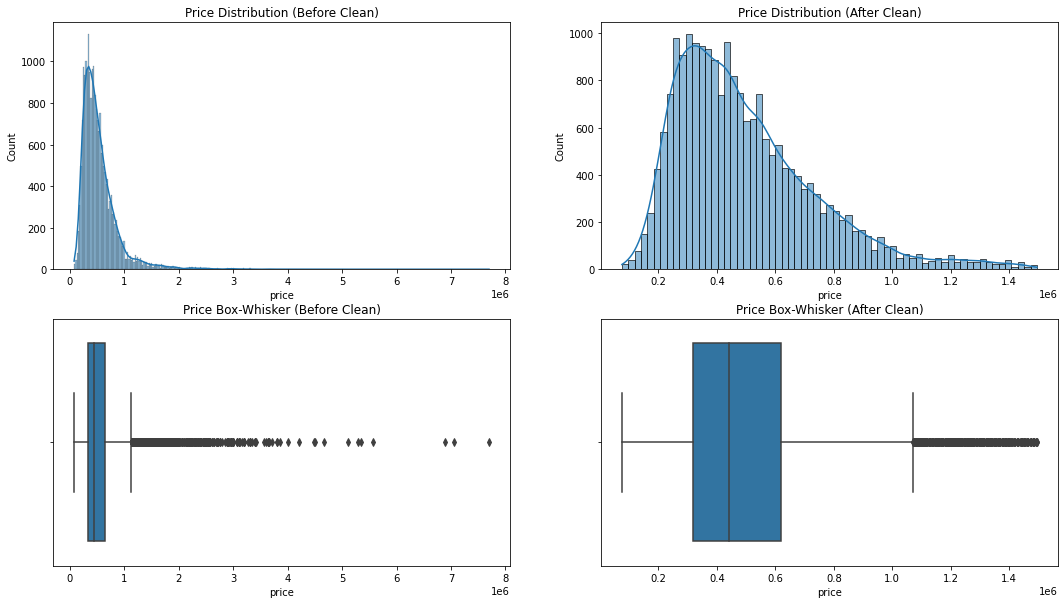

In [8]:
#View Outlier Mgmt
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].set_title('Price Distribution (Before Clean)')
sns.histplot(df_raw['price'], kde=True, ax=axes[0,0]);

axes[1,0].set_title('Price Box-Whisker (Before Clean)')
sns.boxplot(x=df_raw['price'],ax=axes[1,0]);

axes[0,1].set_title('Price Distribution (After Clean)')
sns.histplot(df['price'], kde=True, ax=axes[0,1]);

axes[1,1].set_title('Price Box-Whisker (After Clean)')
sns.boxplot(x=df['price'], ax=axes[1,1]);

In [ ]:
#Engineer Days since prev_sold and peep corr

## EDA 🔍
- _Univariate_ Analysis of Price
- _Bivariate_ Analysis
- Correlation
- Sig. Testing

#### Distributions, Correlation, Multidimensional Viz 

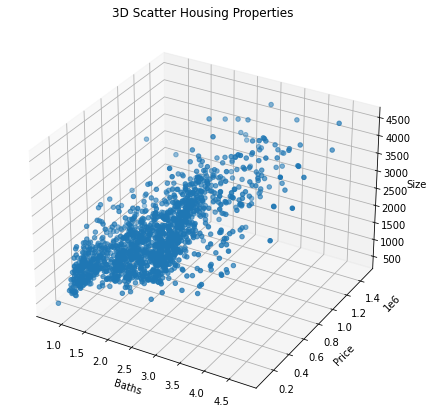

In [9]:
#QI DATA
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

sampled_df = df.sample(n=1500) #Sample df for Viz

ax.scatter(sampled_df['bathrooms'], sampled_df['price'], sampled_df['sqft_living'])

ax.set_xlabel('Baths')
ax.set_ylabel('Price')
ax.set_zlabel('Size')
ax.set_title('3D Scatter Housing Properties')
plt.show()

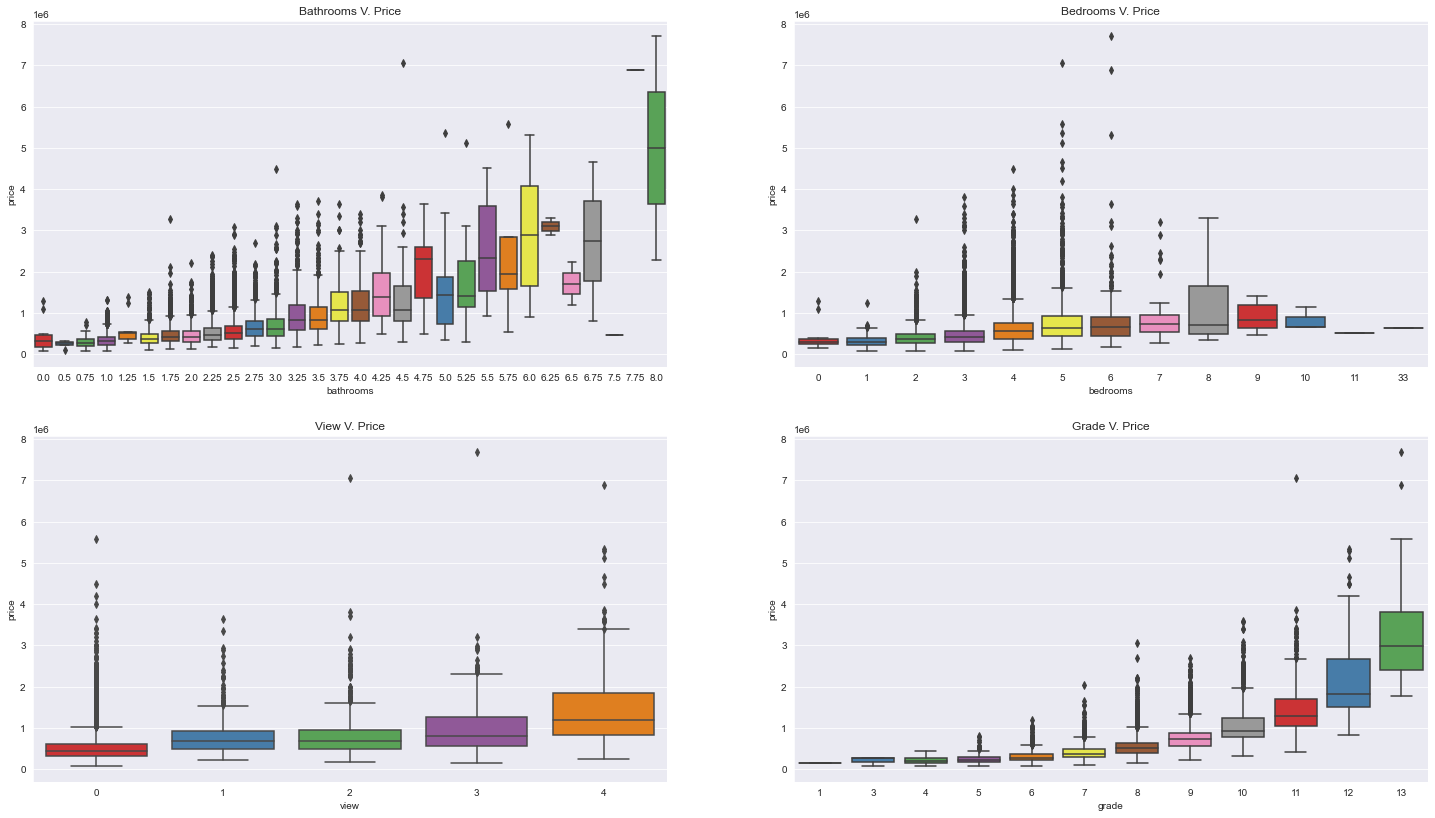

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(25, 14))
sns.set_style("darkgrid")

axes[0,0].set_title('Bathrooms V. Price')
sns.boxplot(x="bathrooms", y="price", data=df_raw, palette="Set1", ax=axes[0,0])

axes[0,1].set_title('Bedrooms V. Price')
sns.boxplot(x="bedrooms", y="price", data=df_raw, palette="Set1", ax=axes[0,1])

axes[1,0].set_title('View V. Price')
sns.boxplot(x="view", y="price", data=df_raw, palette="Set1", ax=axes[1,0])

axes[1,1].set_title('Grade V. Price')
sns.boxplot(x="grade", y="price", data=df_raw, palette="Set1", ax=axes[1,1]);

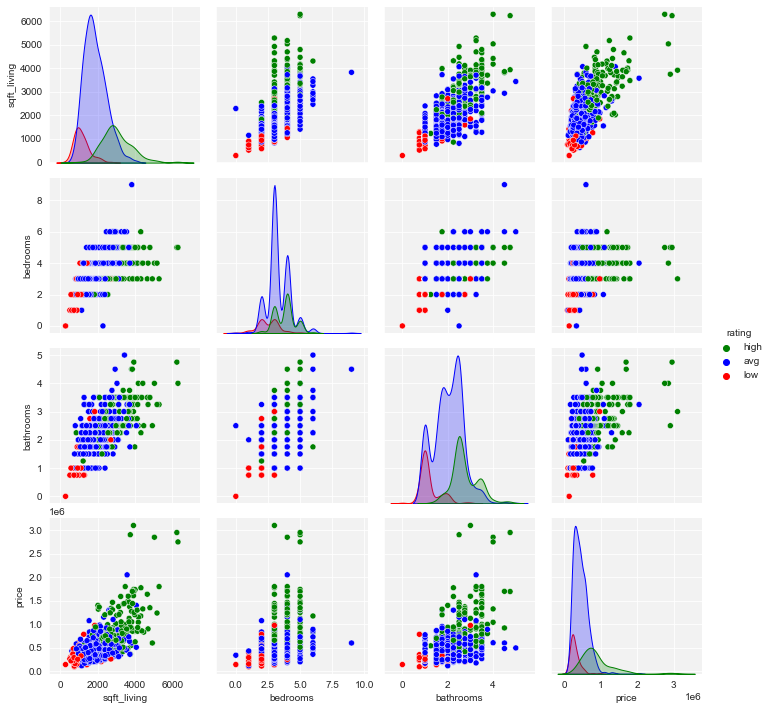

In [14]:
#Col Rating Engineered to better viz Grade
df_raw['rating'] = df_raw['grade'].apply(lambda i: 'low' if i <= 6 else 'avg' if i <= 8 else 'high')
sns.pairplot(data=df_raw[['sqft_living', 'rating', 'bedrooms','bathrooms', 'price']].sample(1000), hue='rating',
            palette={"low": "red", "avg": "blue", "high": "green"});

In [11]:
from sklearn.linear_model import LinearRegression #SQFT_Living LR VIZ
lr = LinearRegression()
lr.fit(np.array(df_raw['sqft_living']).reshape(-1, 1), np.array(df_raw['price']).reshape(-1, 1))

LinearRegression()

In [12]:
bo = lr.intercept_
b1 = lr.coef_
print('Intercept: {} \nSlope (Sqft): {}'.format(bo,b1))

Intercept: [-43580.74309448] 
Slope (Sqft): [[280.6235679]]


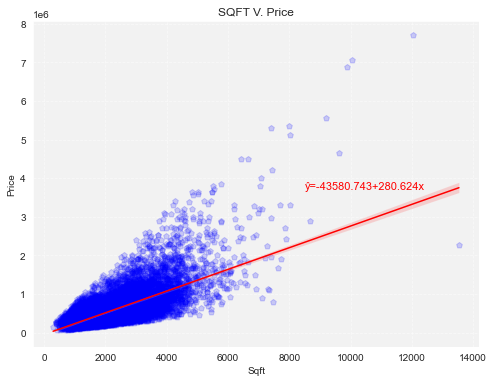

In [13]:
# Create a figure and set the background color
plt.figure(figsize=(8, 6))
 
sns.set_style("darkgrid", {'axes.facecolor': '0.95'})

sns.regplot(df_raw['sqft_living'], df_raw['price'], marker = 'p', scatter_kws={"color": "blue", "alpha": 0.18}, 
    line_kws={"color": "red", "linewidth": 1.5})
plt.xlabel('Sqft')
plt.ylabel('Price')
plt.title('SQFT V. Price')
plt.text(8500, 3700000, f'ŷ={round(bo[0],3)}+{round(b1[0][0],3)}x',fontsize=11, color='red')
plt.grid(True, linestyle='--', alpha=0.5);

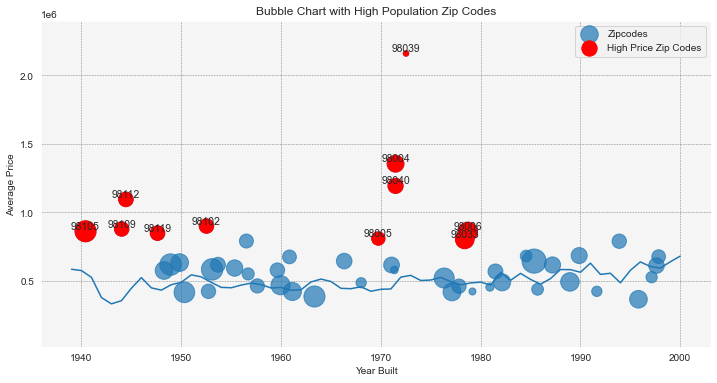

In [15]:
df_raw1 = df_raw.groupby(['zipcode', 'population']).agg({'price':'mean', 'yr_built':'mean'}).\
sort_values(by='price', ascending=False).iloc[0:50].reset_index()

yr_price = pd.DataFrame(df_raw.groupby('yr_built')['price'].mean()).reset_index().query('yr_built >= 1939 & yr_built <= 2000')

high_price_threshold = 60000

high_price_df = df_raw1[df_raw1['price'] >= df_raw1.iloc[10]['price']]

# Create a bubble chart
plt.figure(figsize=(12, 6))
plt.scatter(df_raw1['yr_built'], df_raw1['price'], s=df_raw1['population']/100, alpha=0.7, label='Zipcodes')


plt.scatter(high_price_df['yr_built'], high_price_df['price'], s=high_price_df['population'] / 100, color='red', label="High Price Zip Codes")

# Annotate high population zip codes
for i, row in high_price_df.iterrows():
    plt.annotate(int(row['zipcode']), (row['yr_built'], row['price']), fontsize=10.5, ha='center', va='bottom')

    
    
plt.plot(yr_price['yr_built'], yr_price['price'])
plt.xlabel('Year Built')
plt.ylabel('Average Price')
plt.title('Bubble Chart with High Population Zip Codes')
plt.legend()
plt.ylim(20000, 2400000)

plt.gca().set_facecolor('whitesmoke')

# Add a grid
plt.grid(color='grey', linestyle='--', linewidth=0.5)

plt.show()

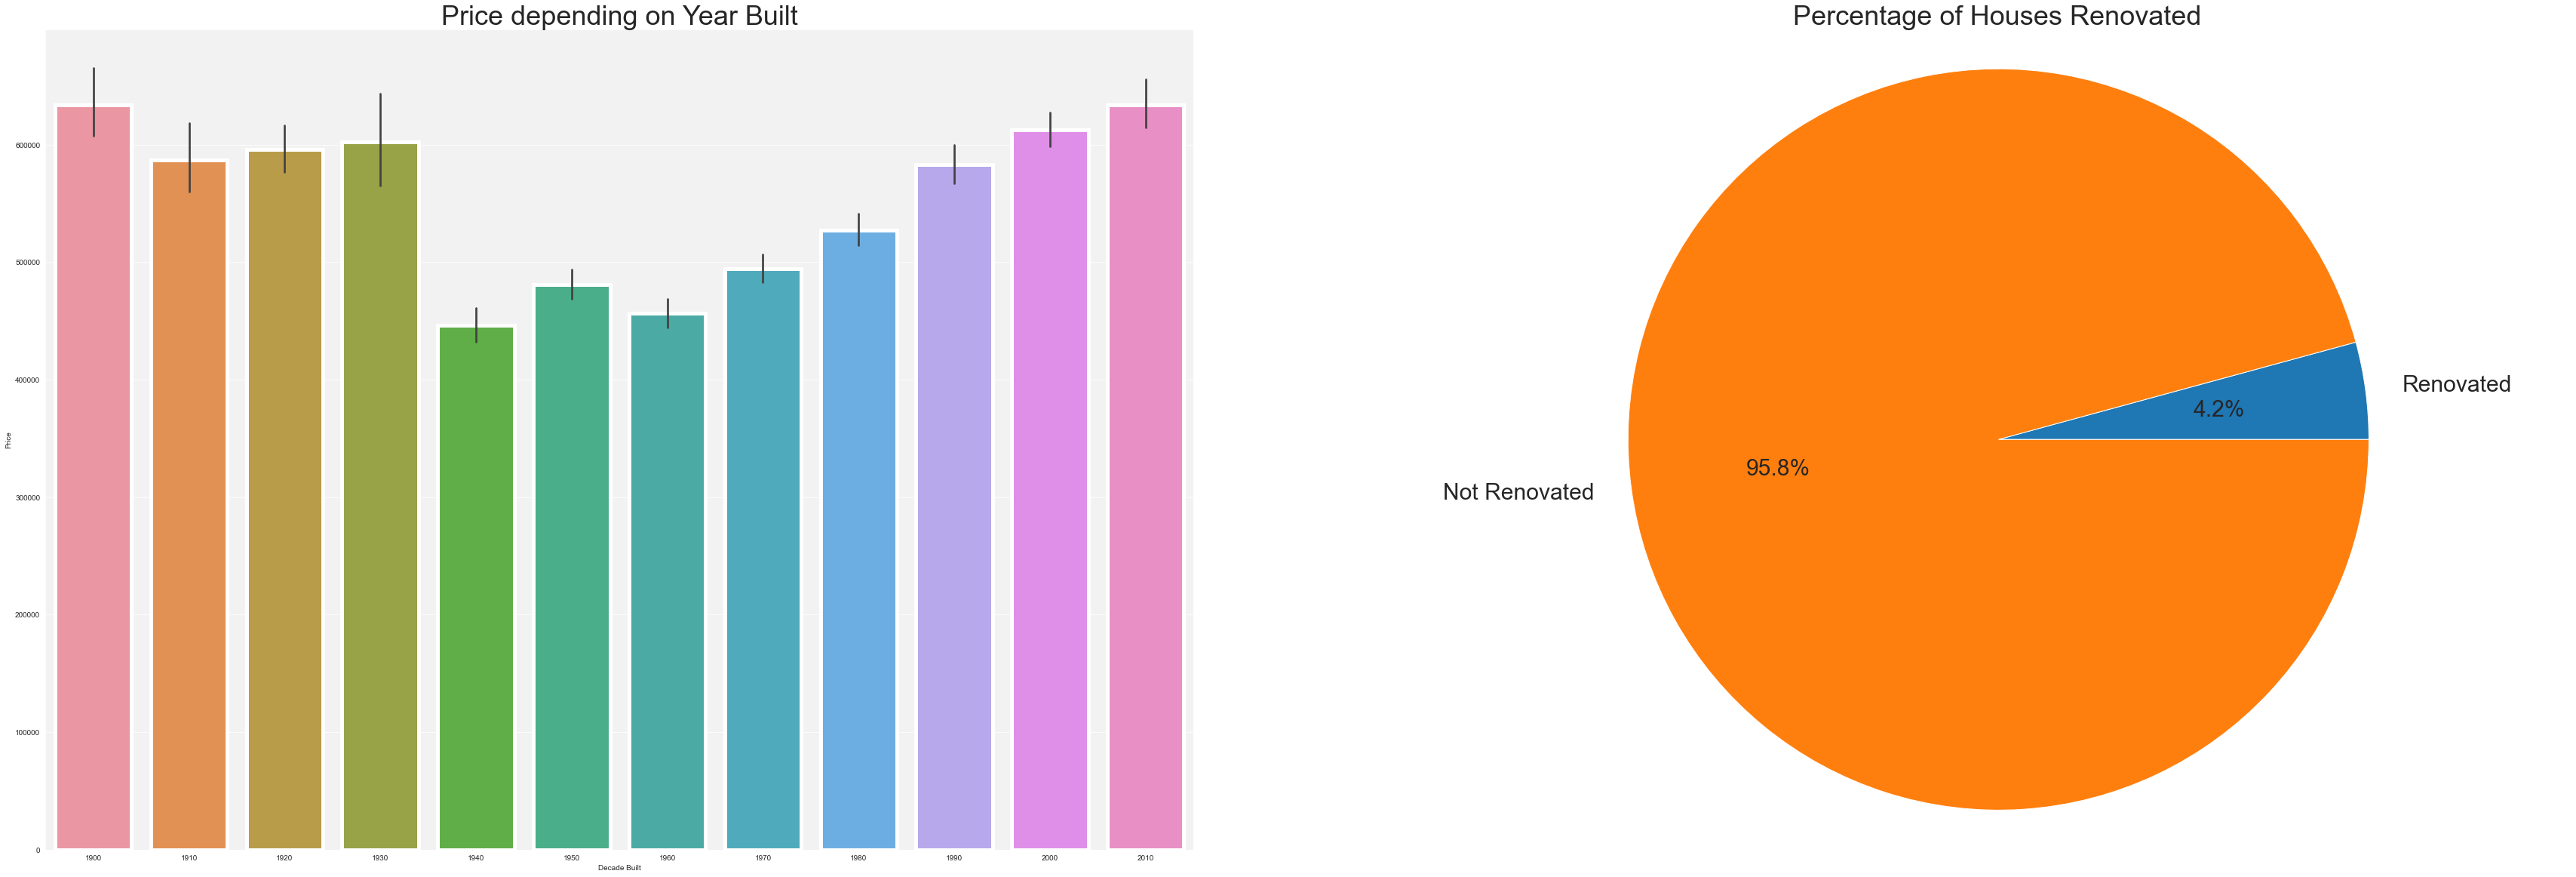

In [16]:
# Now, create a 'Decade' column by integer division to the nearest 10
df_raw['dc_built'] = (df_raw['yr_built'] // 10) * 10

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(60, 20))  # 1 row, 2 columns

plt.rcParams.update({'font.size': 30})

# First subplot: Bar Graph
sns.barplot(x='dc_built', y='price', data=df_raw, lw=5, ax=axs[0])
axs[0].set_title('Price depending on Year Built') 
axs[0].set_xlabel('Decade Built')                 
axs[0].set_ylabel('Price')                        
axs[0].tick_params(axis='x')                      
axs[0].tick_params(axis='y')                      


# Second subplot: Pie Chart
# Count number of houses that have been renovated
renovated_cnt = len(df_raw[df_raw['yr_renovated'] != 0])

# Calculate the total number of houses
total = len(df_raw)

# Calculate percentage
percentage_renovated = (renovated_cnt / total) * 100

# Create a pie chart
labels = ['Renovated', 'Not Renovated']
sizes = [percentage_renovated, 100 - percentage_renovated]

axs[1].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[1].set_title('Percentage of Houses Renovated')
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

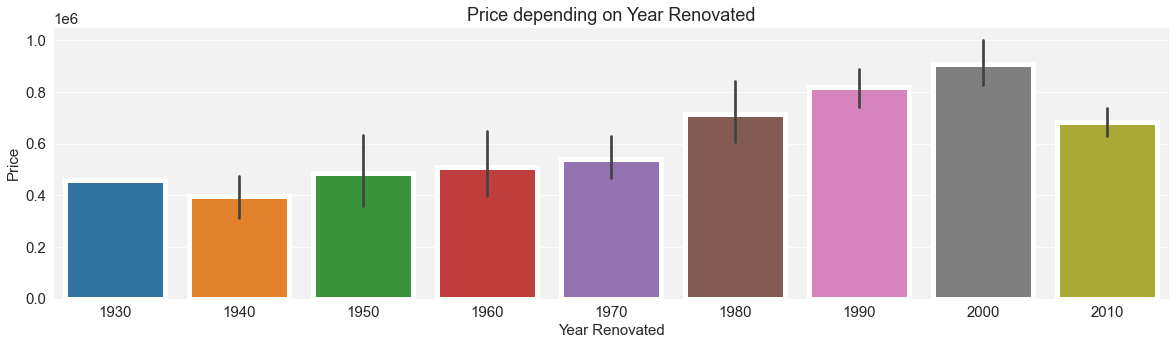

In [17]:
# Now, create a 'Decade' column by integer division to the nearest 10
df_raw['dc_renovated'] = (df_raw['yr_renovated'] // 10) * 10
#Plot bar graph price depending on year built 
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 5))
sns.barplot(x='dc_renovated', y='price', data=df_raw[df_raw['yr_renovated'] != 0], lw=5)
plt.title('Price depending on Year Renovated')
plt.xlabel('Year Renovated')
plt.ylabel('Price');

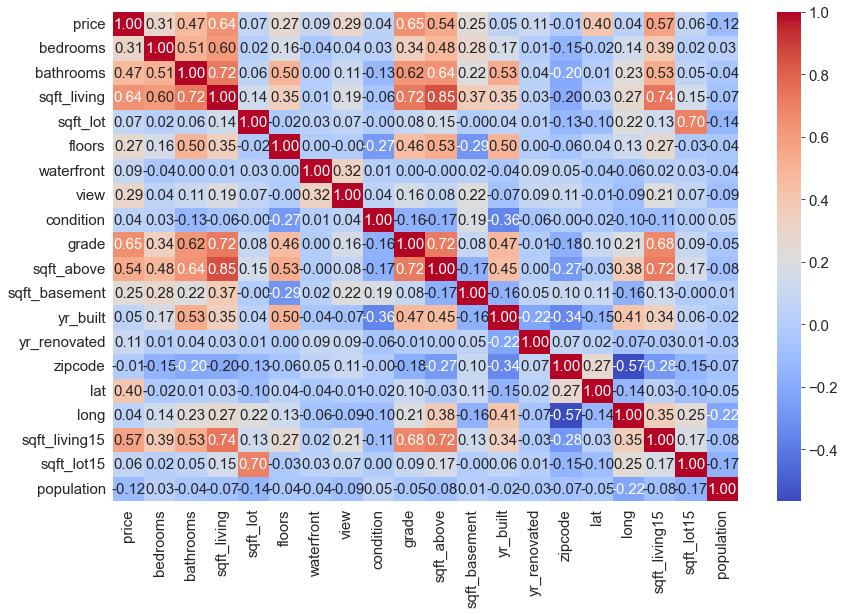

In [20]:
sns.set_style('whitegrid')
plt.figure(figsize=(14,9))
sns.heatmap(df.drop(columns=['OID_', 'id']).corr(), cmap='coolwarm', annot=True, fmt='.2f');

## Hypothesis Testing

In [ ]:
# (Sheba)

# K-means Clustering 
- `k = 5`
> **_Luxury_:
Label Homes as Low End, Average, and High on basis of clustering property features highest correlated w/ price to 5 randomly placed centroids on basis of Scaled Eucilidean Distance 
`vars = price, house_size, bathrooms`**

In [21]:
#Import Scaling+Clustering Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [22]:
df.reset_index(inplace=True)
df_k = df.copy() #df for K-means processes

### _Normalize Features_

In [23]:
#Normalize to Z-scores
scaler = StandardScaler()
df_k[['price_T', 'house_size_t', 'bath_t']] = scaler.fit_transform(df_k[['price', 'sqft_living', 'bathrooms']])

### _Elbow Function_
- Identify optimal K value respecting SSE of Eucidlidean Distance to Respective Centroid

In [24]:
def elbow(data, max_k): #Identify optimal K value respecting SSE
    k_vals = []
    sse = []
    
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        k_vals.append(k)
        sse.append(kmeans.inertia_)
        
    #Elbow Plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(k_vals, sse, 'o-')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.grid(True)
    plt.show()

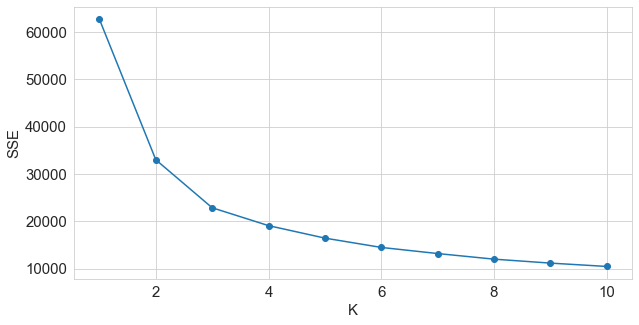

In [25]:
elbow(df_k[['price_T', 'house_size_t', 'bath_t']], 10) #QI DATA

## K-means Clustering Application
- `Luxury`

In [59]:
#Fit K-Means Cluster on highest Corr features w/ Price
kmeans = KMeans(n_clusters=5, random_state=0) #Fit data to Kmeans Algo
kmeans.fit(df_k[['price_T', 'bath_t', 'house_size_t']])

KMeans(n_clusters=5, random_state=0)

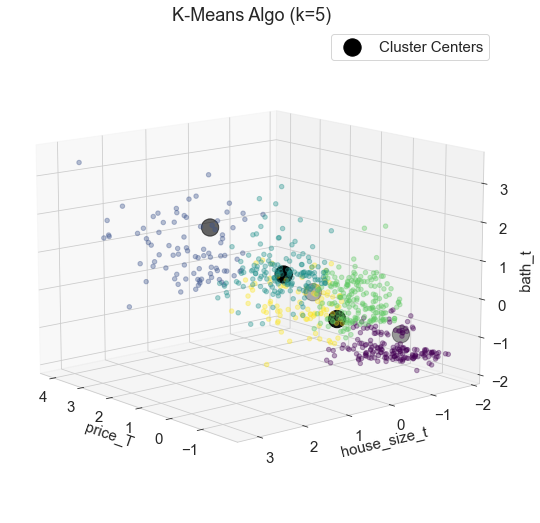

In [60]:
df_k['rating_lux'] = kmeans.labels_ #Labels added to k_means df
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')  # 3D scatter plot

df_k_sampled = df_k.sample(700, random_state=100)  # Sample df for Viz

# Adjust marker style, color, size, and transparency for the scatter points
scatter = ax.scatter(df_k_sampled['price_T'], df_k_sampled['house_size_t'], df_k_sampled['bath_t'],
                     c=df_k_sampled['rating_lux'], cmap='viridis', s=20, marker='o', alpha=.36)

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=300, marker='o', edgecolors='k', label='Cluster Centers')

ax.set_xlabel('price_T')
ax.set_ylabel('house_size_t')
ax.set_zlabel('bath_t')
ax.set_title('K-Means Algo (k=5)')
ax.legend()

ax.view_init(elev=13, azim=140)
plt.show()

In [61]:
df['rating_lux'] = kmeans.labels_ #Labels added to main df

### K-Means Summary

In [62]:
print('SSE:', kmeans.inertia_)

SSE: 16419.747087572687


In [64]:
#Assign Weights to features in order to sort and rate by 'Luxury'
cluster_df = df_k.groupby('rating_lux').agg({'price_T':'mean', 'house_size_t':'mean', 'bath_t':'mean'})
cluster_df['Weighted_Val'] = cluster_df.price_T*.2 + cluster_df.house_size_t*.6 + cluster_df.bath_t*.2
cluster_df = cluster_df.sort_values(by='Weighted_Val')
cluster_df

,price_T,house_size_t,bath_t,Weighted_Val
rating_lux,,,,
0,-0.720812,-1.066686,-1.337743,-1.051722
3,-0.591701,-0.358283,0.108837,-0.311543
4,0.741238,-0.058771,-0.320094,0.048966
2,0.175109,0.772764,0.790831,0.656846
1,1.920789,1.727852,1.252597,1.671388


In [67]:
kmeans.cluster_centers_

array([[-0.71996468, -1.33708406, -1.06590359],
       [ 1.92273721,  1.25309738,  1.72782184],
       [ 0.17614199,  0.79182608,  0.77504176],
       [-0.5904652 ,  0.10950023, -0.35703066],
       [ 0.74378223, -0.31706099, -0.05661733]])

In [65]:
#Initialize Rating 
map_ = {k:v for k,v in zip(cluster_df.index, [5,4,3,2,1])}
df['rating_lux'] = df['rating_lux'].map(map_)

# Modeling Tasks
#### **Regression** - Predict Home Prices 💲🏡
- `Multiple Linear Regression` - _Coefficient + Trend analysis_
- `Gradient Boosted RF Regression`
- `XGBoost`

### Multiple Linear Regression
### $$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n + \epsilon $$

- Coefficient Analysis between lineary associated variables
- Analysis of R2 & Feature Significance

In [68]:
import statsmodels.api as sm

#Initialize Predictors & Outcome
Y = df['price']
X = df[['bathrooms', 'bedrooms', 'sqft_living',
       'grade', 'view', 'floors', 'yr_built']]

In [69]:
#OLS Model (Coef Analysis)
ols_model = sm.OLS(Y, sm.add_constant(X))

# Apply HAC Covariance to Adjust for Multicolinearity  
results = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 5})
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     2968.
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:32:38   Log-Likelihood:            -2.7891e+05
No. Observations:               20884   AIC:                         5.578e+05
Df Residuals:                   20876   BIC:                         5.579e+05
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.508e+06   9.79e+04     56.238      

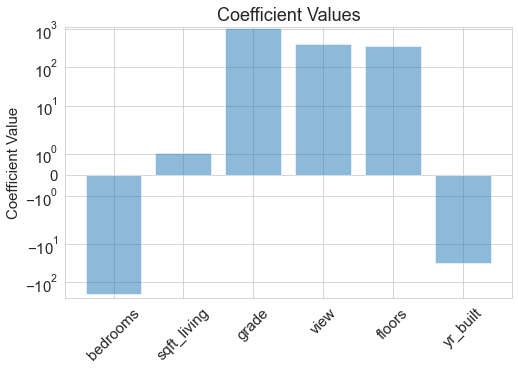

In [70]:
import matplotlib.pyplot as plt
import numpy as np


coefficients = results.params[1:]

plt.figure(figsize=(8, 5))  

x = np.arange(len(coefficients.index[1:]))
y =  [x/100 for x in coefficients.values[1:]]

plt.bar(x, y, align='center', alpha=0.5)

plt.ylabel('Coefficient Value')
plt.title('Coefficient Values')

plt.xticks(x, coefficients.index[1:], rotation=45)

plt.yscale('symlog')
plt.show()


## Tree-Based Methods
- `Random Forest Regression +Boosting`
- `XGBoost`
- `GWR`

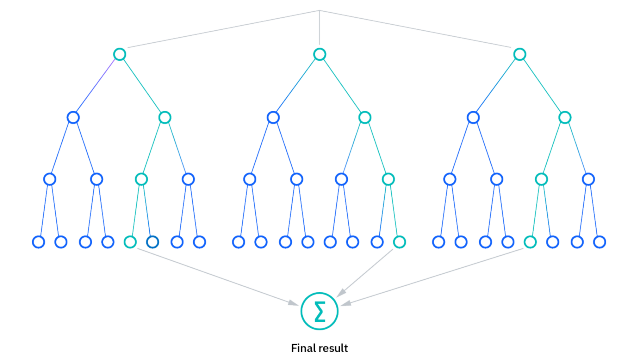

## Random Forest Regressor 🌲
- `Gradient Boosting`
- _Optimize Hyperparameters_ - `GridSearchCV` (3-Fold Cross Validaiton)
- Analyze Loss + Performance Metrics

In [34]:
#Import ML Libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score

In [35]:
#Split - Train/Test
x_train, x_test, y_train, y_test = train_test_split(df[['bedrooms', 'bathrooms', 'sqft_living',
                                                        'floors', 'view', 'condition', 'grade',
                                                       'sqft_basement', 'yr_built', 'yr_renovated',
                                                       'population']], df['price'], test_size=.2,
                                                   random_state=0)

In [61]:
#Search space 
param_map = {
    'n_estimators' : [100, 130, 170],
    'max_depth' : [3, 5, 8]
} ## 130 - 170 --> +tune learning rate/min_samples

scorer = make_scorer(r2_score)
gs= GridSearchCV(estimator=GradientBoostingRegressor(loss='squared_error'),
                           param_grid=param_map,
                           scoring=scorer,
                           cv=3,
                           verbose=4)

gs.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END .....max_depth=3, n_estimators=100;, score=0.742 total time=  29.2s
[CV 2/3] END .....max_depth=3, n_estimators=100;, score=0.730 total time=  28.9s
[CV 3/3] END .....max_depth=3, n_estimators=100;, score=0.727 total time=  29.1s
[CV 1/3] END .....max_depth=3, n_estimators=130;, score=0.768 total time=  38.2s
[CV 2/3] END .....max_depth=3, n_estimators=130;, score=0.763 total time=  37.8s
[CV 3/3] END .....max_depth=3, n_estimators=130;, score=0.758 total time=  37.7s
[CV 1/3] END .....max_depth=3, n_estimators=170;, score=0.791 total time=  50.1s
[CV 2/3] END .....max_depth=3, n_estimators=170;, score=0.782 total time=  50.1s
[CV 3/3] END .....max_depth=3, n_estimators=170;, score=0.779 total time=  49.3s
[CV 1/3] END .....max_depth=5, n_estimators=100;, score=0.808 total time=  41.5s
[CV 2/3] END .....max_depth=5, n_estimators=100;, score=0.804 total time=  40.4s
[CV 3/3] END .....max_depth=5, n_estimators=100;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5, 8],
                         'n_estimators': [100, 130, 170]},
             scoring=make_scorer(r2_score), verbose=4)

In [62]:
#Loss function Analysis
gs.best_params_ #Optimal HyperParameters

{'max_depth': 5, 'n_estimators': 170}

In [36]:
gbr = GradientBoostingRegressor(loss='squared_error', n_estimators=170, max_depth=5)
gbr.fit(x_train, y_train) #Fit model

GradientBoostingRegressor(max_depth=5, n_estimators=170)

<div class="alert alert-block alert-success">
<b>Gradient Boosted Regression Summary:</b> *Best Parameters - {'max_depth': 5, 'n_estimators': 170}
*Test R2 Score (3-Fold Cross Validation ) - .812
</div>

## Loss Function
- Mean Squared Error:
## $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

> Estimaters apply gradient boosting on error predictions w/ learning rate 0.1 at each stage to minimize error and shift toward global minima

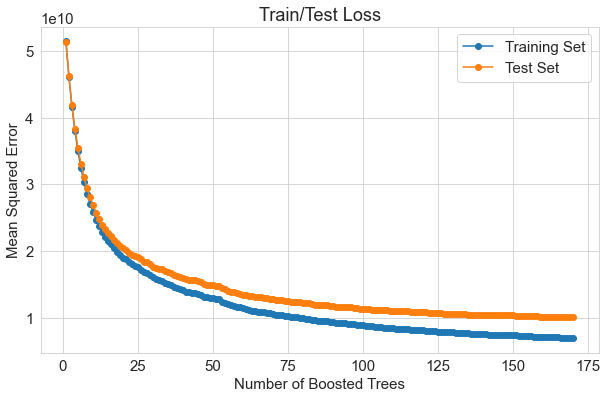

In [71]:
train_errors = [mean_squared_error(y_train, pred) for pred in list(gbr.staged_predict(x_train))]
test_errors = [mean_squared_error(y_test, pred) for pred in list(gbr.staged_predict(x_test))]


plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, gbr.n_estimators + 1), train_errors, label='Training Set', marker='o')
plt.plot(np.arange(1, gbr.n_estimators + 1), test_errors, label='Test Set', marker='o')
plt.xlabel('Number of Boosted Trees')
plt.ylabel('Mean Squared Error')
plt.title('Train/Test Loss')
plt.legend()
plt.show()

### Feature Importances

In [72]:
#Sorted Feature Importances
f_imp = sorted(np.vstack((gbr.feature_importances_, gbr.feature_names_in_)).T,key=lambda i: i[0], reverse=True)

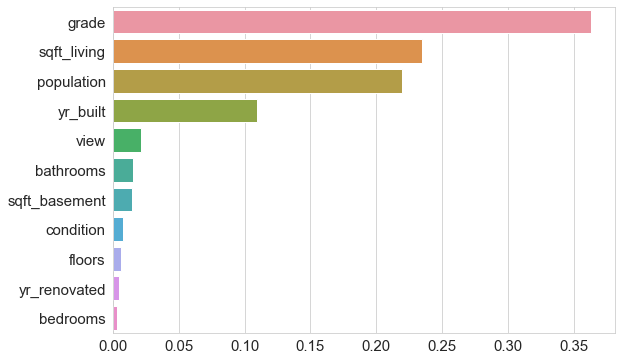

In [75]:
import seaborn as sns
plt.figure(figsize=(9,6))
sns.barplot(x=[i[0] for i in f_imp], y=[i[1] for i in f_imp]);

In [76]:
#Price Estimates Added 
df['price_est'] = gbr.predict(df[['bedrooms', 'bathrooms', 'sqft_living','floors', 'view', 'condition', 
                                  'grade', 'sqft_basement', 'yr_built', 'yr_renovated','population']])

### Performance Metrics
- _Function to Return Modeling Metrics (Regress)_
#### $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $
#### $ \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100 $
#### $ \text{ME} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) $
#### $ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $

In [77]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def performance(y_true, y_pred):
    return pd.DataFrame({'MAPE': [mean_absolute_percentage_error(y_true, y_pred)],
             'MSE':[mean_squared_error(y_true, y_pred)],
             'RMSE': [np.sqrt(mean_squared_error(y_true, y_pred))],
             'ME': [np.mean(y_true-y_pred)]}).rename(index={0:'Results'})


In [78]:
performance(y_test, gbr.predict(x_test)) #Metrics for Gradient Boosted RF Regressor

,MAPE,MSE,RMSE,ME
Results,0.152221,1.007309e+10,100364.780296,2486.233575


In [69]:
"""
To DO:
2.) Other model/gradient characteristics to show (Feature Importances)
4.) XGBoost
5.) Functionize/clean notebook
"""

'\nTo DO:\n2.) Other model/gradient characteristics to show\n3.) Return Summary Stats\n4.) XGBoost\n5.) Functionize/clean notebook\n'

### XGBoost

In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

In [84]:
#Gridsearch Hyper-Parameters
param_map = {
    'n_estimators': [100, 150],
    'max_depth': [6, 9, 12],
    'gamma': [1, 10],
    'learning_rate': [.1, .3, .4]
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)

scorer = make_scorer(r2_score)
gs= GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', booster='gbtree', 
                                         random_state=42),
                           param_grid=param_map,
                           scoring=scorer,
                           cv=kf,
                           verbose=4)
gs.fit(x_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END gamma=1, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.810 total time=   0.3s
[CV 2/3] END gamma=1, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.807 total time=   0.3s
[CV 3/3] END gamma=1, learning_rate=0.1, max_depth=6, n_estimators=100;, score=0.812 total time=   0.3s
[CV 1/3] END gamma=1, learning_rate=0.1, max_depth=6, n_estimators=150;, score=0.825 total time=   0.5s
[CV 2/3] END gamma=1, learning_rate=0.1, max_depth=6, n_estimators=150;, score=0.819 total time=   0.5s
[CV 3/3] END gamma=1, learning_rate=0.1, max_depth=6, n_estimators=150;, score=0.827 total time=   0.5s
[CV 1/3] END gamma=1, learning_rate=0.1, max_depth=9, n_estimators=100;, score=0.811 total time=   0.8s
[CV 2/3] END gamma=1, learning_rate=0.1, max_depth=9, n_estimators=100;, score=0.802 total time=   0.9s
[CV 3/3] END gamma=1, learning_rate=0.1, max_depth=9, n_estimators=100;, score=0.815 total time=   0.9s
[C

[CV 1/3] END gamma=10, learning_rate=0.3, max_depth=9, n_estimators=100;, score=0.807 total time=   0.9s
[CV 2/3] END gamma=10, learning_rate=0.3, max_depth=9, n_estimators=100;, score=0.799 total time=   0.9s
[CV 3/3] END gamma=10, learning_rate=0.3, max_depth=9, n_estimators=100;, score=0.808 total time=   1.0s
[CV 1/3] END gamma=10, learning_rate=0.3, max_depth=9, n_estimators=150;, score=0.805 total time=   1.7s
[CV 2/3] END gamma=10, learning_rate=0.3, max_depth=9, n_estimators=150;, score=0.797 total time=   1.6s
[CV 3/3] END gamma=10, learning_rate=0.3, max_depth=9, n_estimators=150;, score=0.805 total time=   1.6s
[CV 1/3] END gamma=10, learning_rate=0.3, max_depth=12, n_estimators=100;, score=0.775 total time=   1.5s
[CV 2/3] END gamma=10, learning_rate=0.3, max_depth=12, n_estimators=100;, score=0.773 total time=   1.4s
[CV 3/3] END gamma=10, learning_rate=0.3, max_depth=12, n_estimators=100;, score=0.777 total time=   1.4s
[CV 1/3] END gamma=10, learning_rate=0.3, max_depth=

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid={'gamma': [1, 10], 'learning_rate': [0.1, 0.3, 0.4],
                         'max_depth': [6, 9, 12], 'n_estimators': [100, 150]},
             scoring=make_scorer(r2_score), verbose=4)

In [86]:
gs.best_score_, gs.best_params_ #View Optimized Results

(0.8265968172871387,
 {'gamma': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100})

In [80]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, booster='gbtree', gamma=1,
                   learning_rate=.3, max_depth=6, random_state=42) #Fit Optimized XGB

xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [81]:
performance(y_test, xgb.predict(x_test))

,MAPE,MSE,RMSE,ME
Results,0.144128,9.792227e+09,98955.680367,2221.462883


In [82]:
#Add y-hat
df['price_est'] = xgb.predict(df[['bedrooms', 'bathrooms', 'sqft_living','floors', 'view', 'condition', 
                                  'grade', 'sqft_basement', 'yr_built', 'yr_renovated','population']])

### K-Means Clustering
- `Flip-Value Score`

In [83]:
#Create price margin column
df['price_margin'] = df['price'] - df['price_est']

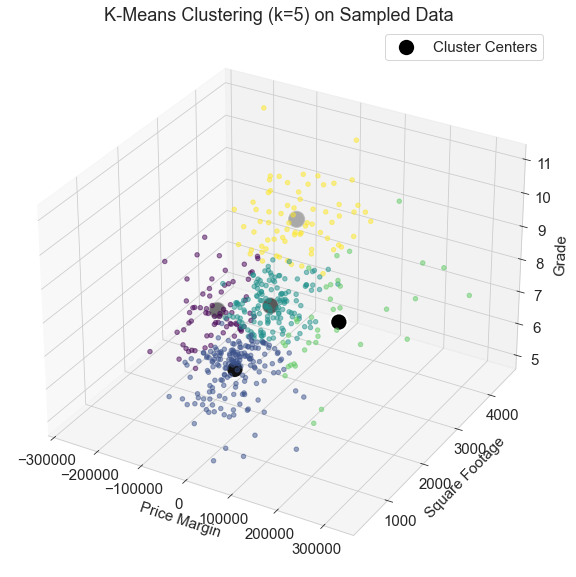

In [84]:
#Initialize the scaler
scaler = StandardScaler()

#Scale the features to add to the k-means
df_scaled = scaler.fit_transform(df[['price_margin', 'sqft_living', 'grade']])

#Fit the K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_scaled)

#Assign the cluster labels to df
df['flip_rating'] = kmeans.labels_

#Get the cluster centers
centers_scaled = kmeans.cluster_centers_

#Inverse transform the cluster centers to original...
centers = scaler.inverse_transform(centers_scaled)

#Downsample the data to see better in plot
df.reset_index(drop=True, inplace=True)

#Use min function to ensure sample size not greater than size of df
sample_size = min(500, len(df))

#Get random indeces for sampling
indices = np.random.choice(df.index, size=sample_size, replace=False)
df_sampled = df.iloc[indices]

#Inverse scale the sampled data for viz purposes
df_sampled_scaled = scaler.inverse_transform(df_scaled[indices])

#Plot the clusters, cluster centers, and the data points using sampled data
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_sampled_scaled[:, 0], df_sampled_scaled[:, 1], df_sampled_scaled[:, 2],
                     c=df_sampled['flip_rating'], cmap='viridis', s=20, marker='o', alpha=0.5)

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           c='black', s=300, marker='o', edgecolors='white', linewidths=2, label='Cluster Centers')


ax.set_xlim(-300000, 350000)

# Set axis labels and title
ax.set_xlabel('Price Margin')
ax.set_ylabel('Square Footage')
ax.set_zlabel('Grade')
ax.set_title('K-Means Clustering (k=5) on Sampled Data')
ax.legend()

plt.show()

### K-Means Summary

In [85]:
print('SSE:', kmeans.inertia_)

SSE: 23349.494666504354


In [87]:
grouped = df.groupby('flip_rating').agg({'price_margin': 'mean', 'sqft_living': 'mean', 'grade': 'mean'})
grouped['Weighted_val'] = -.25*grouped.price_margin + .25*grouped.sqft_living + .5*grouped.grade
grouped = grouped.sort_values(by='Weighted_val')
grouped

,price_margin,sqft_living,grade,Weighted_val
flip_rating,,,,
3,160329.497271,2208.244414,7.823290,-39526.401569
2,10367.178388,2187.313172,7.725823,-2041.103392
1,5564.183603,1301.378078,6.671721,-1062.365521
4,-15333.311209,3205.692429,9.274763,4639.388291
0,-85052.180827,1902.235204,7.488713,21742.348364


In [88]:
#Initialize Ranking change in df
map_ = {k:v for k,v in zip(grouped.index, [5,4,3,2,1])}

df['flip_rating'] = df['flip_rating'].map(map_)

In [90]:
df.rename(columns={'rating_lux':'lux_rating'}, inplace=True)

## Mapping of Computed Scores 🌎
- `Luxury & Flip Rating`
> **1-5 stars ⭐️**

In [ ]:
#Arno





